## Plots comparison of interpretability performance for CNNs with log-based activations

Figures generated in this notebook:
- Supplementary Fig. 11

In [1]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
import helper

from tfomics import utils

Using TensorFlow backend.


In [4]:
results_path = os.path.join('../results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = os.path.join(results_path, 'scores')


# load data
data_path = '../data/synthetic_code_dataset.h5'
data = helper.load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]
X_model = test_model[true_index][:500]


In [5]:
activations = ['relu', 'relu_l2', 'log_relu', 'log_relu_l2']
score_names = ['saliency_scores']

num_trials = 10

model_name = 'cnn-dist'
results = {}
for activation in activations:
    name = model_name+'_'+activation
    results[name] = {}

    file_path = os.path.join(save_path, name+'.pickle')
    with open(file_path, 'rb') as f:            
        saliency_scores = cPickle.load(f)
        #mut_scores = cPickle.load(f)
        #integrated_scores = cPickle.load(f)
        #shap_scores = cPickle.load(f)

    all_scores = [saliency_scores]#, mut_scores, integrated_scores, shap_scores]

    for score_name, scores in zip(score_names, all_scores):
        shap_roc = []
        shap_pr = []
        for trial in range(num_trials):
            if 'mut' in score_name:
                trial_scores = np.sqrt(np.sum(scores[trial]**2, axis=-1, keepdims=True)) * X
            else:
                trial_scores = scores[trial] * X
            roc_score, pr_score = helper.interpretability_performance(X, trial_scores, X_model)
            shap_roc.append(np.mean(roc_score))
            shap_pr.append(np.mean(pr_score))    

        results[name][score_name] = [np.array(shap_roc), np.array(shap_pr)]
        print('%s: %.4f+/-%.4f\t'%(name+'_'+score_name, 
                                   np.mean(results[name][score_name][0]), 
                                   np.std(results[name][score_name][0]))) 



cnn-dist_relu_saliency_scores: 0.7300+/-0.0443	
cnn-dist_relu_l2_saliency_scores: 0.7466+/-0.0152	
cnn-dist_log_relu_saliency_scores: 0.7556+/-0.0241	
cnn-dist_log_relu_l2_saliency_scores: 0.7865+/-0.0255	


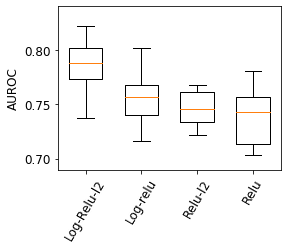

In [6]:
names = ['Log-Relu-l2', 'Log-relu', 'Relu-l2', 'Relu']
score_name = 'saliency_scores'
fig = plt.figure(figsize=(4,3))
ax = plt.subplot(1,1,1)
vals = [results['cnn-dist_log_relu_l2'][score_name][0], 
        results['cnn-dist_log_relu'][score_name][0],
        results['cnn-dist_relu_l2'][score_name][0], 
        results['cnn-dist_relu'][score_name][0],
       ]
ax.boxplot(vals,  widths = 0.6);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.7, 0.75, 0.8], fontsize=12)
plt.xticks(np.linspace(1,4,4), names, fontsize=12, rotation=60)
ax.set_ybound([.69,0.84])
ax.set_xbound([.5,4.5])
outfile = os.path.join(results_path, 'task3_compare_attr_score_auroc_log.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

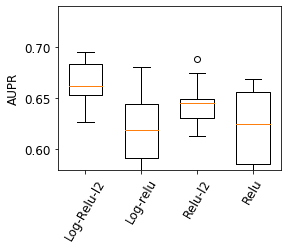

In [7]:
names = ['Log-Relu-l2', 'Log-relu', 'Relu-l2', 'Relu']

fig = plt.figure(figsize=(4,3))
ax = plt.subplot(1,1,1)
vals = [results['cnn-dist_log_relu_l2'][score_name][1], 
        results['cnn-dist_log_relu'][score_name][1],
        results['cnn-dist_relu_l2'][score_name][1], 
        results['cnn-dist_relu'][score_name][1],
       ]
ax.boxplot(vals,  widths = 0.6);
plt.ylabel('AUPR', fontsize=12)
plt.yticks([ 0.6, 0.65, 0.7], fontsize=12)
plt.xticks(np.linspace(1,4,4), names, fontsize=12, rotation=60)
ax.set_ybound([.58,0.74])
ax.set_xbound([.5,4.5])
outfile = os.path.join(results_path, 'task3_compare_attr_score_pr_log.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')